# MS022 Preprocess
06/18/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'MS022'
subj_format = ['edf']
subj_site = ['MSSM']


### Import Data

In [5]:
edf_files = glob(f'{neural_dir}/MS022/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


In [6]:
mne_data

<RawEDF | MS022_SWB.edf, 148 x 2913024 (2844.7 s), ~3.21 GB, data loaded>

In [7]:
mne_data.ch_names

['LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LplfO1',
 'LplfO2',
 'LplfO3',
 'LplfO4',
 'LplfO5',
 'LplfO6',
 'LpCSMA1',
 'LpCSMA2',
 'LpCSMA3',
 'LpCSMA4',
 'LpCSMA5',
 'LpCSMA6',
 'LpCSMA7',
 'LpCSMA8',
 'LpCSMA9',
 'LpCSMA10',
 'LAglT1',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'LAglT10',
 'LHplT1',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LHplT10',
 'LHplT11',
 'LHplT12',
 'C63',
 'C64',
 'Lles1',
 'Lles2',
 'Lles3',
 'Lles4',
 'Lles5',
 'Lles6',
 'Lles7',
 'Lles8',
 'Fp1',
 'F7',
 'T3',
 'T5',
 'O1',
 'F3',
 'C3',
 'P3',
 'Fp2',
 'F8',
 'T4',
 'T6',
 'O2',
 'F4',
 'C4',
 'P4',
 'Fz',
 'Cz',
 'Pz',
 'EKG1',
 'EKG2',
 'C94',
 'C95',
 'C96',
 'C97',
 'C98',
 'C99',
 'C100

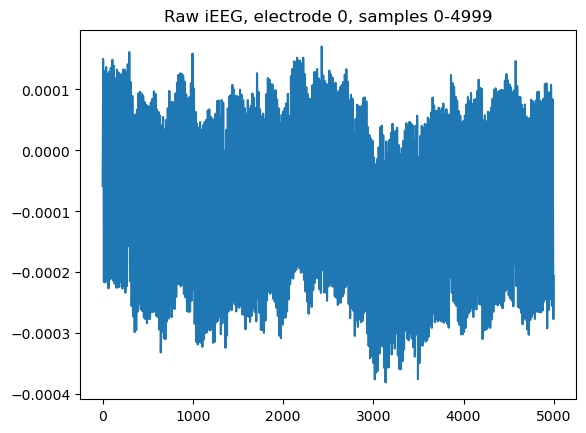

In [8]:
# Sanity check one channel data
plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Examine photodiode

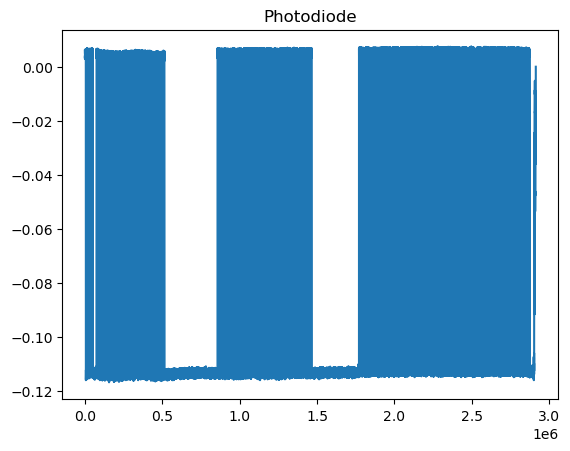

In [9]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

### Import Anat Recon Info - check all elecs are present in data + recon sheet


### Fix edf channel names

In [11]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}/MS022_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,Manual Examination,Notes
0,LaCaS1,A32sg_L,-7.998392,33.753014,11.599995,-7.303106,29.507935,-4.544081,Gray,Left ACgG anterior cingulate gyrus,Area s24,L ACC,L CG,Left cingulate gyrus D,NaN,NaN
1,LaCaS2,Unknown,-11.997591,33.753014,15.199995,-11.263673,31.336920,-0.649451,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,NaN,NaN
2,LaCaS3,Unknown,-15.596870,33.753014,19.199995,-14.826880,33.353221,3.587480,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,NaN,NaN
3,LaCaS4,Unknown,-19.196148,34.551902,21.599995,-18.475267,35.217119,5.812331,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,NaN,NaN
4,LaCaS5,Unknown,-22.395507,34.551902,24.799995,-21.683689,36.761797,9.288654,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,LplfO4,Unknown,-49.590058,-4.194170,19.999995,-47.937431,-2.052692,25.197714,Gray,Left Cerebral White Matter,Unknown,L Precentral Gyrus,Unknown,Unknown,Left posterior motor I,NaN
68,LplfO5,A4hf_L,-54.389097,-3.794726,21.599995,-52.836611,-1.118054,26.762258,Gray,Left Cerebral White Matter,Unknown,L Precentral Gyrus,L PrG,Left posterior motor I,NaN,NaN
69,LplfO6,A4hf_L,-59.987975,-2.995838,23.599995,-58.569705,0.138888,28.441652,Gray,Left PrG precentral gyrus,Unknown,L Precentral Gyrus,L PrG,Left posterior motor I,NaN,NaN
70,uLaCaS,A32sg_L,-5.598873,34.152458,9.999995,-5.000333,29.004945,-6.416785,Gray,Left ACgG anterior cingulate gyrus,Area s24,L ACC,L CG,Left cingulate gyrus D,NaN,NaN


In [12]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LAglT1',
 'LAglT10',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'LHplT1',
 'LHplT10',
 'LHplT11',
 'LHplT12',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'Llesion1',
 'Llesion2',
 'Llesion3',
 'Llesion4',
 'Llesion5',
 'Llesion6',
 'Llesion7',
 'Llesion8',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'LpCSMA1',
 'LpCSMA10',
 'LpCSMA2',
 'LpCSMA3',
 'LpCSMA4',
 'LpCSMA5',
 'LpCSMA6',
 'LpCSMA7',
 'LpCSMA8',
 'LpCSMA9',
 'LplfO1',
 'LplfO2',
 'LplfO3',
 'LplfO4',
 'LplfO5',
 'LplfO6',
 'uLaCaS',
 'uLmOlF']

In [13]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


In [14]:
unmatched_names

['ulmolf', 'ulacas']

In [15]:
unmatched_seeg  #make sure there are no unmatched names

[]

In [16]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [17]:
new_name_dict

{'LmOlF1': 'lmolf1',
 'LmOlF2': 'lmolf2',
 'LmOlF3': 'lmolf3',
 'LmOlF4': 'lmolf4',
 'LmOlF5': 'lmolf5',
 'LmOlF6': 'lmolf6',
 'LmOlF7': 'lmolf7',
 'LmOlF8': 'lmolf8',
 'LmOlF9': 'lmolf9',
 'LaCaS1': 'lacas1',
 'LaCaS2': 'lacas2',
 'LaCaS3': 'lacas3',
 'LaCaS4': 'lacas4',
 'LaCaS5': 'lacas5',
 'LaCaS6': 'lacas6',
 'LaCaS7': 'lacas7',
 'LaCaS8': 'lacas8',
 'LaCaS9': 'lacas9',
 'LmCmS1': 'lmcms1',
 'LmCmS2': 'lmcms2',
 'LmCmS3': 'lmcms3',
 'LmCmS4': 'lmcms4',
 'LmCmS5': 'lmcms5',
 'LmCmS6': 'lmcms6',
 'LplfO1': 'lplfo1',
 'LplfO2': 'lplfo2',
 'LplfO3': 'lplfo3',
 'LplfO4': 'lplfo4',
 'LplfO5': 'lplfo5',
 'LplfO6': 'lplfo6',
 'LpCSMA1': 'lpcsma1',
 'LpCSMA2': 'lpcsma2',
 'LpCSMA3': 'lpcsma3',
 'LpCSMA4': 'lpcsma4',
 'LpCSMA5': 'lpcsma5',
 'LpCSMA6': 'lpcsma6',
 'LpCSMA7': 'lpcsma7',
 'LpCSMA8': 'lpcsma8',
 'LpCSMA9': 'lpcsma9',
 'LpCSMA10': 'lpcsma10',
 'LAglT1': 'laglt1',
 'LAglT2': 'laglt2',
 'LAglT3': 'laglt3',
 'LAglT4': 'laglt4',
 'LAglT5': 'laglt5',
 'LAglT6': 'laglt6',
 'LAglT7': '

In [18]:
# Rename the mne data according to the localization data
mne_data.rename_channels(new_name_dict)

<RawEDF | MS022_SWB.edf, 148 x 2913024 (2844.7 s), ~3.21 GB, data loaded>

In [19]:
unmatched_seeg

[]

In [20]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['c63', 'c64', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'c94', 'c95', 'c96', 'c97', 'c98', 'c99', 'c100', 'c101', 'c102', 'c103', 'c104', 'c105', 'c106', 'c107', 'c108', 'c109', 'c110', 'c111', 'c112', 'c113', 'c114', 'c115', 'c116', 'c117', 'c118', 'c119', 'c120', 'c121', 'c122', 'c123', 'c124', 'c125', 'c126', 'c127', 'c128', 'dc1', 'dc2', 'dc3', 'dc4', 'dc5', 'dc6', 'dc7', 'dc8', 'dc9', 'dc10', 'dc11', 'dc12', 'dc13', 'dc14', 'dc15', 'dc16', 'trig', 'osat', 'pr', 'pleth']


In [21]:
# Note, there is surface EEG data that we should separately indicate from the sEEG:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of', len(left_seeg_names), 'left &', len(right_seeg_names), 'right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')


We have a total of 70 left & 0 right sEEG electrodes
We have a total of 70 sEEG electrodes


In [22]:
list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names+['dc1'])) #list of non seeg/photodiode channels

['c105',
 'c113',
 'fp2',
 'c124',
 'c126',
 'dc14',
 'c115',
 't4',
 'c63',
 'c94',
 'c109',
 'c103',
 'c121',
 'c101',
 'dc12',
 'pz',
 'f7',
 'c118',
 'c102',
 'pleth',
 'c127',
 'c64',
 'dc4',
 'osat',
 'c104',
 'c116',
 'c98',
 'c99',
 'c106',
 't3',
 'dc8',
 'c100',
 'dc3',
 'c108',
 'dc11',
 'dc16',
 'ekg2',
 'c107',
 'ekg1',
 'c96',
 'c123',
 't6',
 'o2',
 'c112',
 'pr',
 'dc6',
 'c117',
 'c95',
 'p3',
 'dc10',
 'fp1',
 'f8',
 'trig',
 'dc9',
 'c97',
 'dc5',
 'f4',
 'c3',
 'dc15',
 'dc7',
 'fz',
 'dc13',
 'c122',
 'c119',
 't5',
 'c111',
 'cz',
 'c120',
 'c128',
 'c4',
 'c125',
 'p4',
 'o1',
 'f3',
 'c114',
 'dc2',
 'c110']

In [23]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names+['dc1']))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs + 1 (photodiode)

<RawEDF | MS022_SWB.edf, 71 x 2913024 (2844.7 s), ~1.54 GB, data loaded>

In [24]:
# Set channel types:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
trig_mapping_dict = {'dc1':'stim'} #stim stands for stimulus
mne_data.set_channel_types(sEEG_mapping_dict)
mne_data.set_channel_types(trig_mapping_dict)

<RawEDF | MS022_SWB.edf, 71 x 2913024 (2844.7 s), ~1.54 GB, data loaded>

In [25]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS022_SWB.edf, 71 x 2913024 (2844.7 s), ~1.54 GB, data loaded>

### Notch filter line noise

In [26]:
# Identify line noise
mne_data.info['line_freq'] = 60

# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    4.7s finished


<RawEDF | MS022_SWB.edf, 71 x 2913024 (2844.7 s), ~1.54 GB, data loaded>

### Resampling Data

In [27]:
#resampling if patient is not sampled at 512
resample_sr = 512
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:    6.6s finished


<RawEDF | MS022_SWB.edf, 71 x 1456512 (2844.7 s), ~789.1 MB, data loaded>

### Save out photodiode data
Note: this is after filtering out line noise and resampling

In [28]:
mne_data.save(f'{neural_dir}/MS022/photodiode.fif', picks='dc1', overwrite=True)

### Detect bad channels - detect_bad_elecs function auto detects, then we validate manually 

In [29]:
#make_mne function auto-detects bad electrodes. I want to compare auto vs manual ictal detection

bads = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #worked perfectly for this pt besides photodiode
mne_data.info['bads'] = bads

In [30]:
bads #bads picked up research? - manually remove
#bads = bads[:-1]
#bads

['lacas4',
 'laglt10',
 'laglt3',
 'lmcms2',
 'lmcms4',
 'lmcms5',
 'lmolf1',
 'lmolf3']

In [31]:
mne_data.info['bads'] = bads

In [32]:
mne_data.info

<Info | 10 non-empty values
 bads: 8 items (lacas4, laglt10, laglt3, lmcms2, lmcms4, lmcms5, ...)
 ch_names: lmolf1, lmolf2, lmolf3, lmolf4, lmolf5, lmolf6, lmolf7, lmolf8, ...
 chs: 70 sEEG
 custom_ref_applied: False
 dig: 70 items (70 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 256.0 Hz
 meas_date: 2001-01-01 14:11:42 UTC
 nchan: 70
 projs: []
 sfreq: 512.0 Hz
>

In [33]:
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)

In [34]:
probe_names

array(['lacas', 'laglt', 'lhplt', 'llesion', 'lmcms', 'lmolf', 'lpcsma',
       'lplfo', 'ulacas', 'ulmolf'], dtype='<U7')

In [37]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [38]:
probe_ch_counts

{'lacas': 9,
 'laglt': 10,
 'lhplt': 12,
 'llesion': 8,
 'lmcms': 6,
 'lmolf': 9,
 'lpcsma': 10,
 'lplfo': 6,
 'ulacas': 1,
 'ulmolf': 1}

<IPython.core.display.Javascript object>


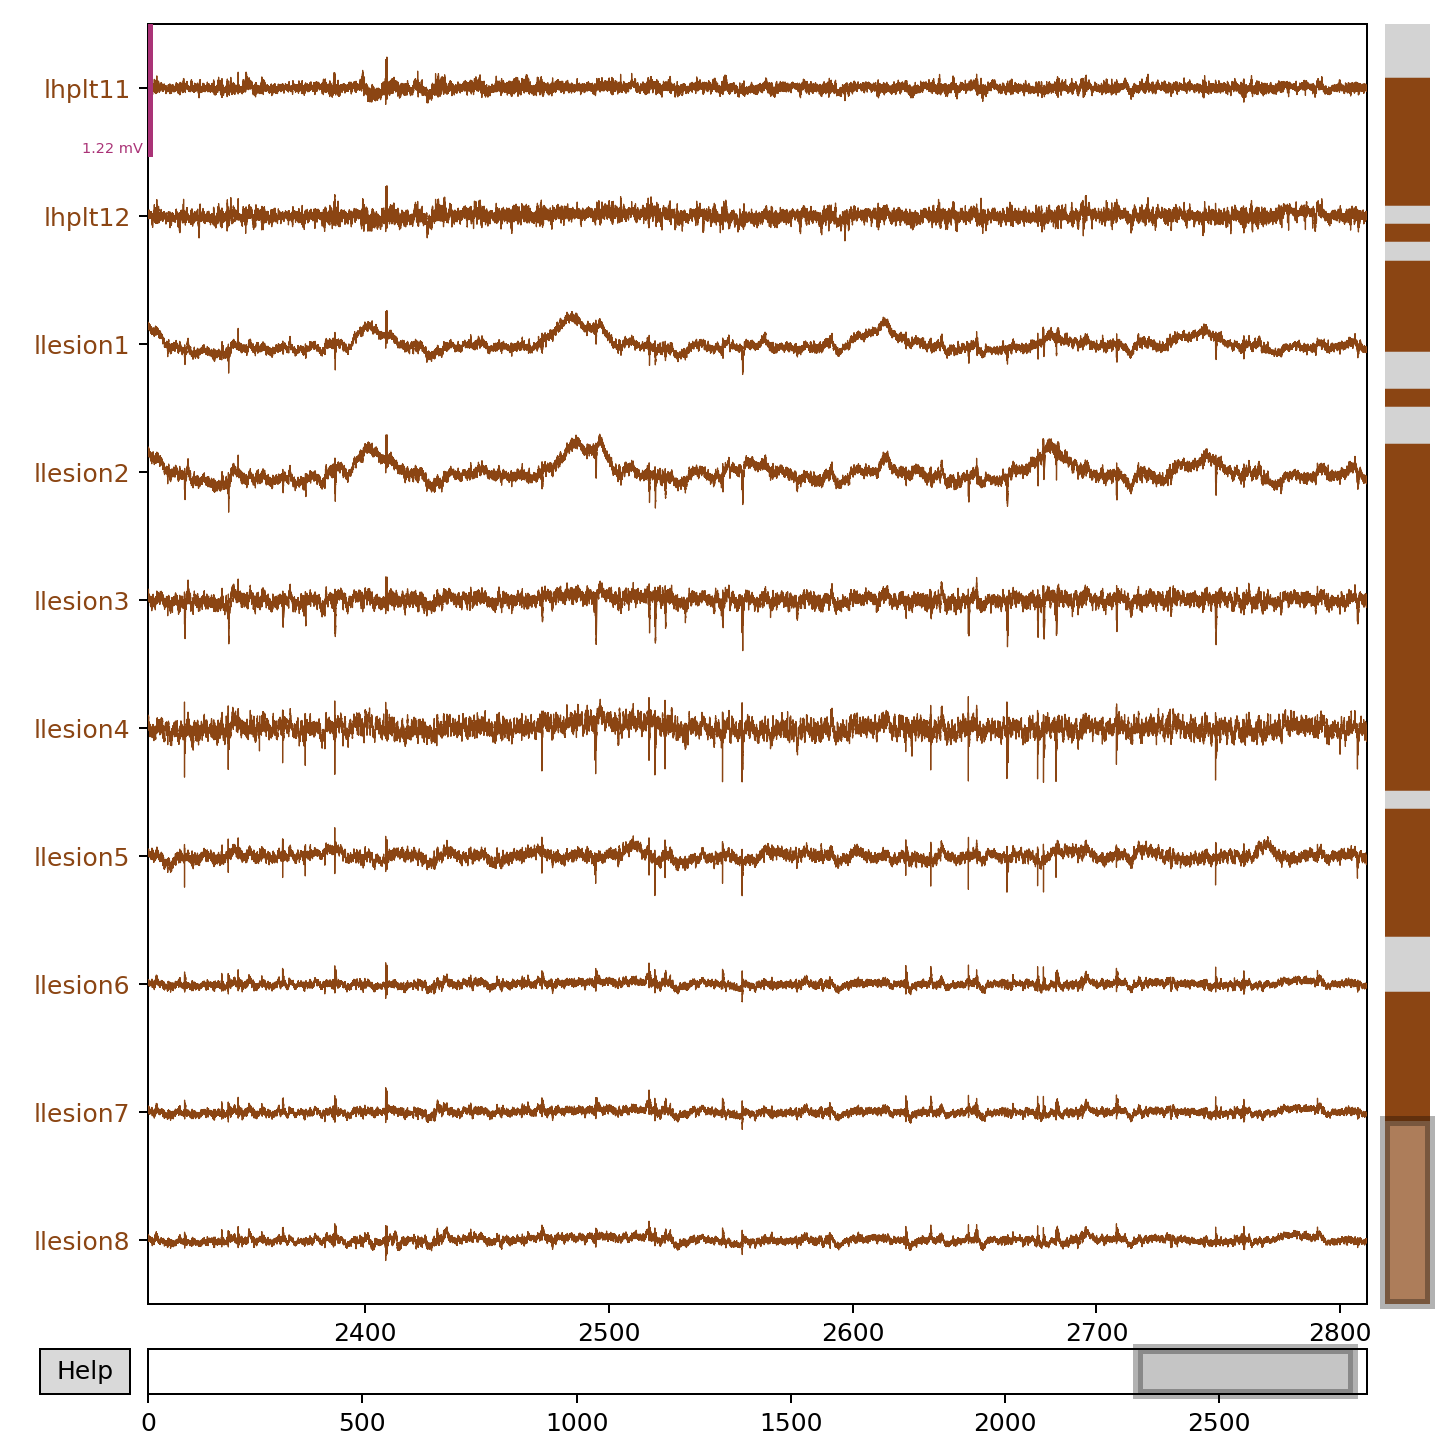

<IPython.core.display.Javascript object>


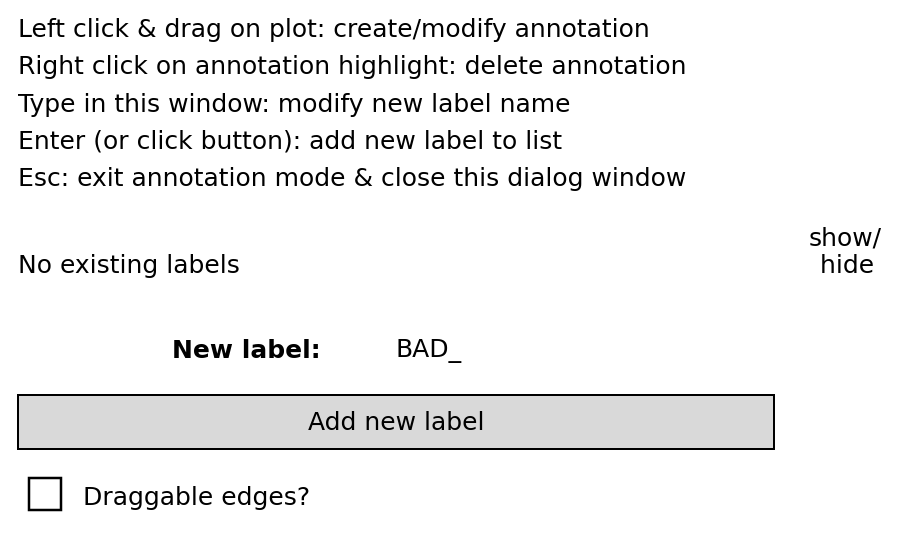

In [39]:
%matplotlib notebook 
fig = mne_data.plot(start=0, duration=500, n_channels=10, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

In [40]:
mne_data.info['bads']

['lacas4',
 'laglt10',
 'laglt3',
 'lmcms2',
 'lmcms4',
 'lmcms5',
 'lmolf1',
 'lmolf3']

<IPython.core.display.Javascript object>


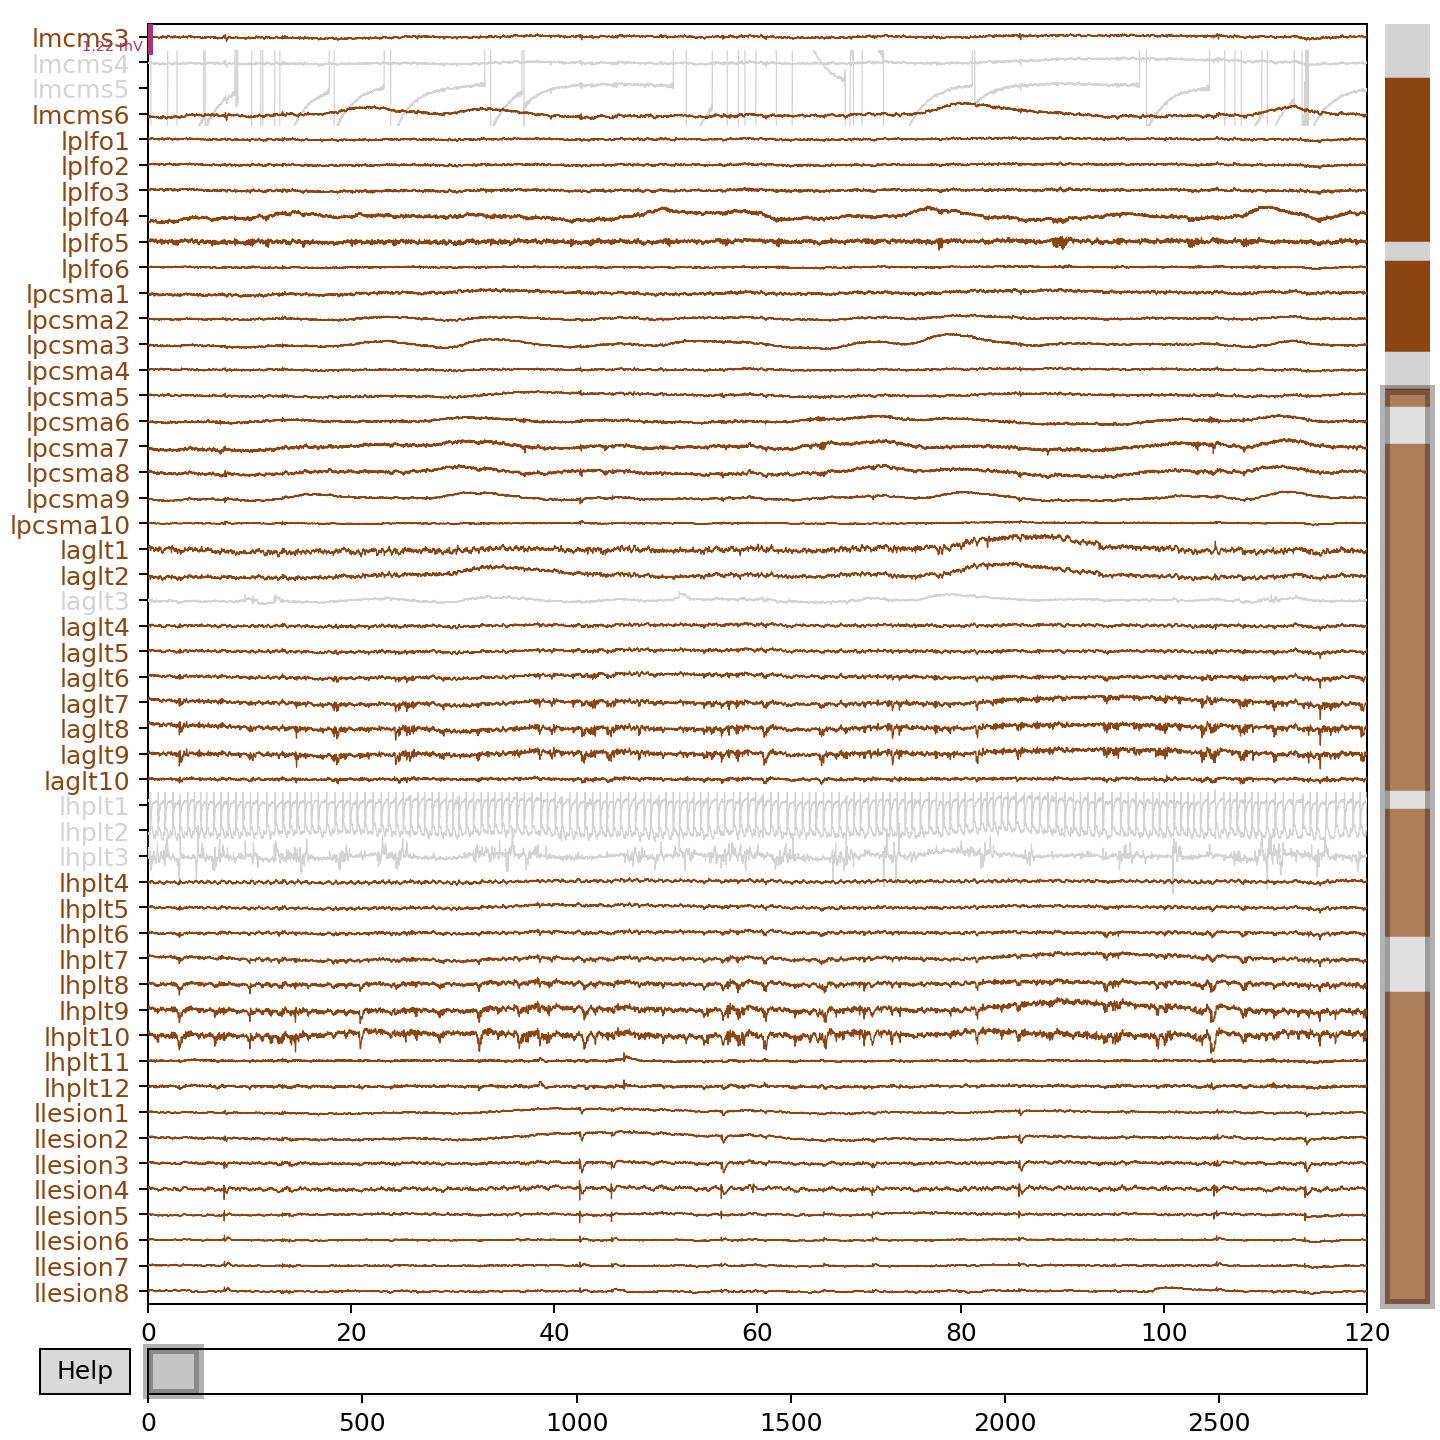

<IPython.core.display.Javascript object>


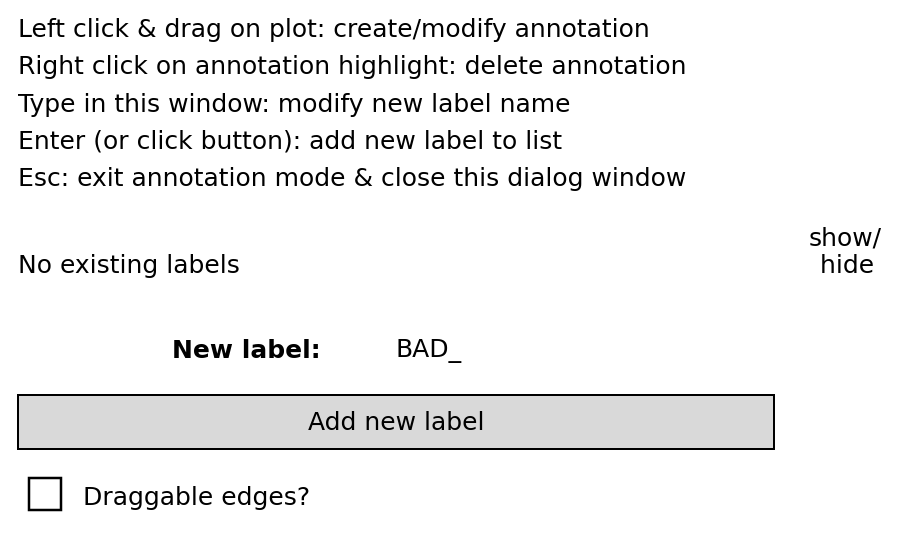

In [41]:
%matplotlib notebook
fig = mne_data.plot(start=0, duration=120, n_channels=50, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

In [42]:
mne_data.info['bads'] 

['lacas4',
 'laglt10',
 'laglt3',
 'lmcms2',
 'lmcms4',
 'lmcms5',
 'lmolf1',
 'lmolf3']

In [43]:
#set bad channel info 
ms022_bad_ch = ['lacas2','lacas4','lhplt1','lhplt2','lhplt3','laglt3','lmcms1','lmcms2','lmcms4','lmcms5','lmolf1','lmolf2','lmolf3']


In [44]:
len(ms022_bad_ch)

13

In [45]:
#manually set bads because doing it in the plot is too buggy
mne_data.info['bads'] = ms022_bad_ch 

In [46]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 13 items (lacas2, lacas4, lhplt1, lhplt2, lhplt3, laglt3, ...)
 ch_names: lmolf1, lmolf2, lmolf3, lmolf4, lmolf5, lmolf6, lmolf7, lmolf8, ...
 chs: 70 sEEG
 custom_ref_applied: False
 dig: 70 items (70 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 256.0 Hz
 meas_date: 2001-01-01 14:11:42 UTC
 nchan: 70
 projs: []
 sfreq: 512.0 Hz
>

In [47]:
mne_data.info['bads'] #more sanity checking

['lacas2',
 'lacas4',
 'lhplt1',
 'lhplt2',
 'lhplt3',
 'laglt3',
 'lmcms1',
 'lmcms2',
 'lmcms4',
 'lmcms5',
 'lmolf1',
 'lmolf2',
 'lmolf3']

### Rereference data to wm electrodes

In [48]:
anode_list, cathode_list, drop_wm_channels, oob_channels = lfp_preprocess_utils.wm_ref(mne_data=mne_data, 
                                                                                elec_path=anat_file, 
                                                                                unmatched_seeg = unmatched_seeg,
                                                                                bad_channels=mne_data.info['bads'],
                                                                                      site = 'MSSM')

In [49]:
oob_channels

['lhplt12', 'llesion7', 'llesion8', 'lmcms6', 'lpcsma10']

In [50]:
#need to distinguish between wm channels and oob channels 

#add oob channels to bad channels list
ms022_bad_ch = ms022_bad_ch + oob_channels
ms022_bad_ch = list(np.unique(ms022_bad_ch))
mne_data.info['bads'] = ms022_bad_ch

In [51]:
mne_data.info['bads'] #needed to rerun plotting function to find this again?

['lacas2',
 'lacas4',
 'laglt3',
 'lhplt1',
 'lhplt12',
 'lhplt2',
 'lhplt3',
 'llesion7',
 'llesion8',
 'lmcms1',
 'lmcms2',
 'lmcms4',
 'lmcms5',
 'lmcms6',
 'lmolf1',
 'lmolf2',
 'lmolf3',
 'lpcsma10']

In [52]:
mne_data_reref = mne.set_bipolar_reference(mne_data, 
                      anode=anode_list, 
                      cathode=cathode_list,
                      copy=True)

In [53]:
mne_data_reref

<RawEDF | MS022_SWB.edf, 56 x 1456512 (2844.7 s), ~622.4 MB, data loaded>

### Save cleaned continuous data

In [54]:
mne_data.save(f'{neural_dir}/MS022/lfp_data.fif',overwrite=True)

In [55]:
mne_data_reref.save(f'{neural_dir}/MS022/wm_ref_ieeg.fif',overwrite=True)